Importación de librerías

In [66]:
import tensorflow as tf
import numpy as np
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from keras import Input
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.image as mpimg

A continuación se cargar los directorios de las imágenes de entrenamiento y testeo, y el tamaño de las imágenes a utilizar.

In [67]:
train_dir = 'melanoma_cancer_dataset/train'
test_dir = 'melanoma_cancer_dataset/test'
IMG_SIZE = (150, 150)

En los siguientes gráficos se observa la distribución entre las clases benignas y malignas.

Train Class Distribution:


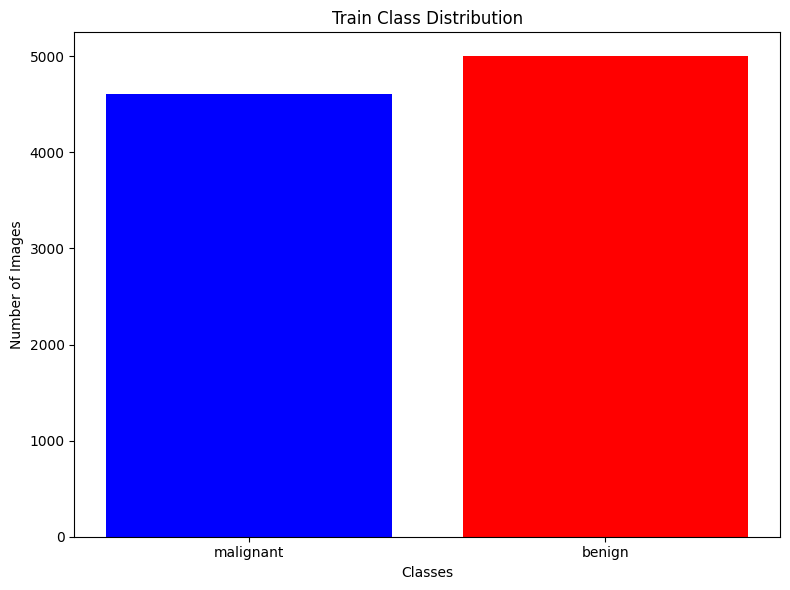

Test Class Distribution:


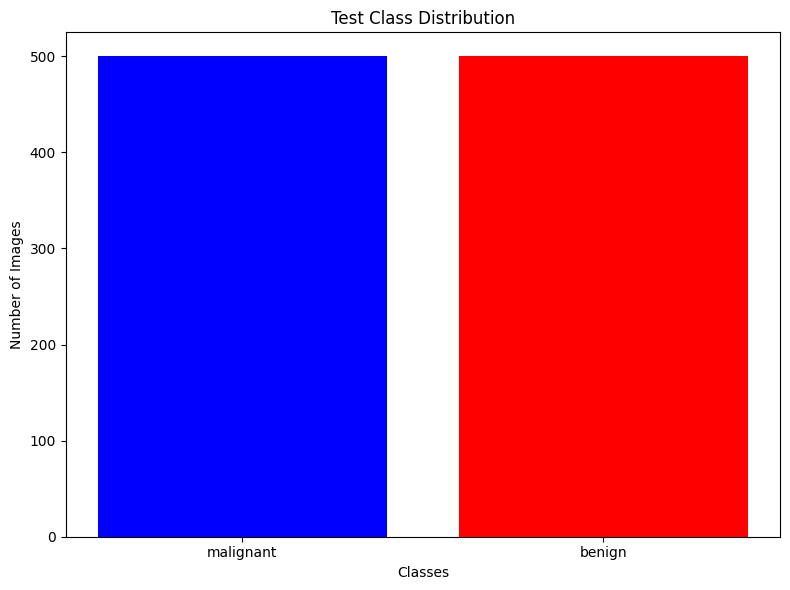

In [68]:
def show_class_distribution(directory, title="Class Distribution"):
    
    class_counts = {}
    
    # Contar imágenes en cada subcarpeta
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    
    # Graficar la distribución
    plt.figure(figsize=(8, 6))
    plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'red'])
    plt.title(title)
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.tight_layout()
    plt.show()
    
print("Train Class Distribution:")
show_class_distribution(train_dir, title="Train Class Distribution")

print("Test Class Distribution:")
show_class_distribution(test_dir, title="Test Class Distribution")

Como se puede observar, las clases se encuentran balanceadas, habiendo una mínima diferencia en el conjunto de entrenamiento. En el conjunto de testeo, el balanceo es perfecto.




Se define una función para cargar las imágenes de un directorio y sus respectivas etiquetas.
Además, se normalizan los valores de los pixeles de las imágenes.

In [69]:
def load_images_from_directory(directory):
    images = []
    labels = []
    for label, subdir in enumerate(['benign', 'malignant']):
        subdir_path = os.path.join(directory, subdir)
        for filename in os.listdir(subdir_path):
            img_path = os.path.join(subdir_path, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, IMG_SIZE)
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)

# Cargar datos y normalizar
X, y = load_images_from_directory(train_dir)
X = X / 255.0

Se divide el conjunto de entrenamiento en entrenamiento y validación.

In [70]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


Se hará una búsqueda de hiperparámetros para encontrar una arquitectura de red neuronal convolucional que se ajuste a los datos. Para ello, se utilizará la librería keras-tuner. 
Se definirá una función que construya el modelo de red neuronal convolucional, varíando los valores de:
- El número de filtros de las capas convolucionales
- El tamaño del kernel
- Las unidades de las capas densas
- La tasa de dropout
- La tasa de aprendizaje

Se harán 20 iteraciones para encontrar la mejor arquitectura.

Se utilizará early_stop para detener el entrenamiento si no se observa mejora en la función de pérdida, ahorrando así tiempo de cómputo.


In [71]:
def build_model(hp):
    model = tf.keras.Sequential([
        Input(shape=(150, 150, 3)),
        tf.keras.layers.Conv2D(
            filters=hp.Int('filters', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice('kernel_size', values=[3, 5]),
            activation='relu'
        ),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            units=hp.Int('units', min_value=64, max_value=256, step=64),
            activation='relu'
        ),
        tf.keras.layers.Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Crear un tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='my_dir2',
    project_name='melanoma_tuning2'
)

# Crear el callback de EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

Además se creó la clase SaveResultsCallback que permitirá guardar los resultados de cada iteración en un archivo csv, junto con gráficos de como varían la función de pérdida y las métricas a medida que aumentan el número de epochs.

In [72]:
class SaveResultsCallback(tf.keras.callbacks.Callback):
    def __init__(self, base_path='results2', folder_name=None):
        super().__init__()
        self.base_path = base_path
        self.folder_name = folder_name

    def on_train_end(self, logs=None):
        # Si se proporciona un nombre, usarlo; de lo contrario, buscar un nombre único
        if self.folder_name:
            trial_folder = os.path.join(self.base_path, self.folder_name)
        else:
            trial_folder = get_unique_trial_folder(self.base_path)

        # Crear la carpeta de resultados
        os.makedirs(trial_folder, exist_ok=True)

        # Guardar resultados en CSV
        history_df = pd.DataFrame(self.model.history.history)
        csv_filename = os.path.join(trial_folder, "trial_results.csv")
        history_df.to_csv(csv_filename, index=False)

        # Graficar y guardar Accuracy
        plt.figure(figsize=(10, 5))
        plt.plot(history_df['accuracy'], label='Train Accuracy')
        plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        accuracy_path = os.path.join(trial_folder, "accuracy.png")
        plt.savefig(accuracy_path)
        plt.close()

        # Graficar y guardar Loss
        plt.figure(figsize=(10, 5))
        plt.plot(history_df['loss'], label='Train Loss')
        plt.plot(history_df['val_loss'], label='Validation Loss')
        plt.title('Loss per Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        loss_path = os.path.join(trial_folder, "loss.png")
        plt.savefig(loss_path)
        plt.close()

        

        print(f"Results and metadata saved to {trial_folder}")

def get_unique_trial_folder(base_path):
    counter = 1
    while os.path.exists(f"{base_path}/trial_{counter}"):
        counter += 1
    return f"{base_path}/trial_{counter}"

Se entrena el modelo con los datos de entrenamiento y validación, con un número máximo de epochs de 50. Al final se obtienen los mejores hiperparámetros encontrados. 

In [73]:
# Crear directorio para guardar resultados
os.makedirs('results2', exist_ok=True)

# Realizar la búsqueda de hiperparámetros
tuner.search(
    X_train, y_train,
    epochs=3,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, SaveResultsCallback()]
)



Trial 5 Complete [00h 01m 01s]
val_accuracy: 0.6991150379180908

Best val_accuracy So Far: 0.8906819224357605
Total elapsed time: 00h 10m 10s

Mejor número de filtros: 32
Mejor tamaño del kernel: 3
Mejor número de unidades: 256
Mejor tasa de aprendizaje: 0.001
Mejor dropout: 0.4



TypeError: can only concatenate str (not "int") to str

In [74]:
# Obtener el mejor modelo
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Mejor número de filtros: {best_hps.get('filters')}
Mejor tamaño del kernel: {best_hps.get('kernel_size')}
Mejor número de unidades: {best_hps.get('units')}
Mejor tasa de aprendizaje: {best_hps.get('learning_rate')}
Mejor dropout: {best_hps.get('dropout')}
""")

best_trial_id = None
for trial_id, trial in tuner.oracle.trials.items():
    if trial.hyperparameters.values == best_hps.values:
        best_trial_id = trial_id
        break

print(f"El mejor trial fue: {int(best_trial_id) + 1}")


Mejor número de filtros: 32
Mejor tamaño del kernel: 3
Mejor número de unidades: 256
Mejor tasa de aprendizaje: 0.001
Mejor dropout: 0.4

El mejor trial fue: 4


Una vez obtenidos los mejores hiperparámetros, se procede a obtener el modelo correspondiente, guardarlo como archivo y mostrar sus gráficos correspondientes.

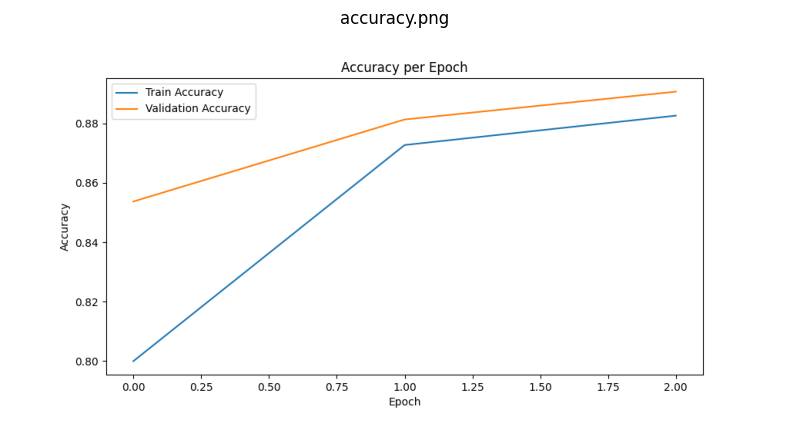

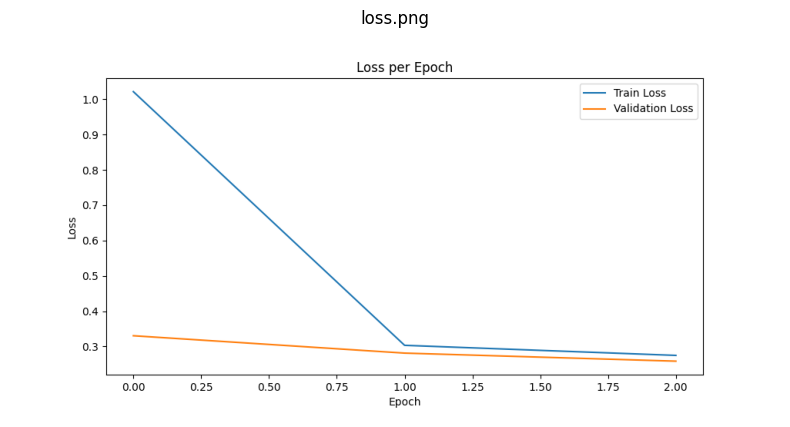

In [77]:
def display_images(image_paths):
    for image_path in image_paths:
        if image_path and os.path.exists(image_path):
            img = mpimg.imread(image_path)
            plt.figure(figsize=(10, 5))
            plt.imshow(img)
            plt.axis('off')  # Ocultar los ejes
            plt.title(os.path.basename(image_path))  # Mostrar el nombre del archivo como título
            plt.show()
        else:
            print(f"Image not found: {image_path}")

# Mostrar las imágenes
display_images([f'results2/trial_{int(best_trial_id) + 1}/accuracy.png', f'results2/trial_{int(best_trial_id) + 1}/loss.png'])
# Obtener el mejor modelo entrenado desde Keras Tuner
best_model = tuner.get_best_models(num_models=1)[0]

# Guardar el modelo como archivo HDF5
best_model.save('best_melanoma_model_tuned.h5')

A continuación se evaluará el modelo con los datos de testeo. A partir de las predicciones se calcularán las métricas de accuracy, precision, recall y f1-score. Además, se graficará la matriz de confusión.

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

Resultados del modelo:
Accuracy: 0.90

Reporte de clasificación:
              precision    recall  f1-score   support

      Benign       0.87      0.94      0.90       500
   Malignant       0.93      0.85      0.89       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.89      1000
weighted avg       0.90      0.90      0.89      1000



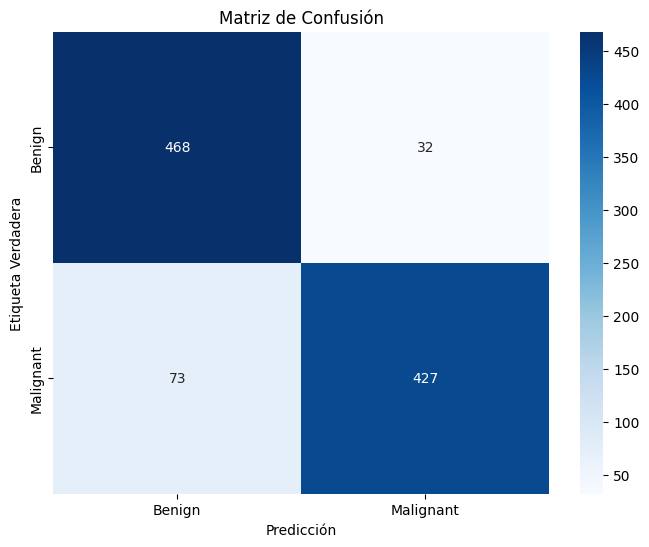

In [78]:
def evaluate_model(test_folder, model_path=None):
    # Cargar el modelo guardado
    model = tf.keras.models.load_model(model_path)

    # Cargar imágenes de la carpeta de prueba
    X_test, y_test = load_images_from_directory(test_folder)
    X_test = X_test / 255.0  # Normalizar imágenes

    # Realizar predicciones
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int).flatten()  # Convertir a 0 o 1

    # Calcular y mostrar métricas
    print("\nResultados del modelo:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print("\nReporte de clasificación:")
    print(classification_report(y_test, y_pred, target_names=['Benign', 'Malignant']))

    # Crear matriz de confusión
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Graficar matriz de confusión
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Verdadera')
    plt.show()

evaluate_model(test_dir)